In [49]:
import warnings
warnings.filterwarnings("ignore")

from appaloosa import RunLC
import os
import pandas as pd

def RunLC_cluster(oid,run,C='05',cluster='M67',LCtype='everest'):
    folder = 'stars_shortlist'
    loc = '{}/{}/results/{}'.format(folder,cluster,run)
    tpf_loc = '{}/{}/ktwo{}-c05_lpd-targ.fits.gz'.format(folder,cluster,oid)
    if LCtype == 'everest':
        lc_loc = '{}/{}/hlsp_everest_k2_llc_{}-c{}_kepler_v2.0_lc.fits'.format(folder,cluster,oid,C)
        mode = 3
    elif LCtype == 'k2sc':
        lc_loc = '{}/{}/hlsp_k2sc_k2_llc_{}-c{}_kepler_v2_lc.fits'.format(folder,cluster,oid,C)
        mode = 5
    home = '/home/ekaterina/Documents/appaloosa'
    #os.chdir(home)
    fakes = RunLC(lc_loc, dbmode=LCtype, display=False, debug=False, 
                  dofake=True, writeout=True, respath='{}/{}'.format(home,loc),
                  nfake=20, iterations=300, mode=mode)
    return fakes

In [54]:
cluster = 'Pleiades'
C = '04'
test = 'run_11'
LCtype = 'k2sc'
#ID = 211104312
os.chdir('/home/ekaterina/Documents/appaloosa')
print(os.getcwd())
params = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
#print(params.tail())
oid_list = params.EPIC.tolist()
ID = 211104755
params.EPIC.to_csv('stars_shortlist/{0}/{0}_IDs_{1}.txt'.format(cluster, test),
                  header=False, index=False)

/home/ekaterina/Documents/appaloosa


In [55]:
#os.chdir('/home/ekaterina/Documents/appaloosa/appaloosa')
for i, oid in enumerate([ID]):
    print('\nThis is the {}th light curve in the current pipeline.\n'.format(i))
    print(os.getcwd())
    fakes = RunLC_cluster(oid, run=test, C=C, cluster=cluster,LCtype=LCtype)
    fakes.to_csv("/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/{}_{}_allfakes.csv".format(cluster,test,oid,LCtype))
 #   for item in ['flares','flux']:
 #       os.rename("/home/ekaterina/Documents/appaloosa/{}_{}.csv".format(oid,item),
 #                 "/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/{}_{}.csv".format(cluster,test,oid,item))

os.rename('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/flarelist.txt'.format(cluster,test),
          '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/{0}_{1}_flarelist.txt'.format(cluster,test))


This is the 0th light curve in the current pipeline.

/home/ekaterina/Documents/appaloosa


In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def falsepos(fakes):
    false = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    false['ed_ratio']=false.ed_rec/false.ed_fake
    false = false.sort_values(by='ed_ratio')
    #print(false[false.ed_ratio>1].shape[0]/false.shape[0])
    falsepos = false[false.ed_ratio>1.]


    f, (ax1, ax2,ax3) = plt.subplots(3, sharex=True,figsize=(6,9))

    ax1.hist(fakes.ed_fake, bins=(1,10,100,1000,10000,100000),
             histtype='step',linewidth=2,color='k')
    ax1.set_title('EPIC {}'.format(ID))
    ax1.set_ylabel('\# injected flares')

    ax2.scatter(falsepos.ed_rec,falsepos.ed_ratio, 
                s=falsepos.ed_rec_err/falsepos.ed_rec*1e3,
                color='k',alpha=0.75)
    ax2.axhline(y=1.,color='r')
    ax2.axhline(y=1.1,color='r',linestyle='dashed')
    plt.xscale('log')
    ax2.set_yscale('log')

    plt.xlabel('recovered ED in s')
    ax2.set_ylabel('recovered fraction\n of injected ED')


    ax3.hist(fakes.ed_rec, bins=(1,10,100,1000,10000,100000),
             histtype='step',linewidth=2,color='k')

    ax3.set_ylabel('\# recovered flares')


    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/false_positives_{}.jpg'.format(LCtype),dpi=300)
    return

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def ratio(fakes):
    f = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    f = f[f.ed_rec>1]


    plt.figure(figsize=(7,5))

    plt.scatter(f.ed_rec,f.ed_ratio,s=f.ed_rec_err/f.ed_rec*1e3, alpha=0.5,color='k',
                label='$\sigma_{ED}/ED$')
    plt.axhline(y=1.,color='r')
    plt.axhline(y=1.1,color='r',linestyle='dashed')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim((0.1,1.5))
    plt.xlim((1,1e5))
    plt.xlabel('recovered ED in s')
    plt.ylabel('recovered fraction of injected ED')
    plt.title('EPIC {}'.format(ID))
    plt.legend(loc=4, frameon=False)
    plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/ed_ratio_{}.jpg'.format(LCtype),dpi=300)
    return

In [81]:
def fprate(fakes,LCtype):
    false = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    false['ed_ratio']=false.ed_rec/false.ed_fake
    false.ed_ratio = false.ed_ratio.astype('float')
    false = false.sort_values(by='ed_ratio')
    overall_false_pos = false[false.ed_ratio>1.].shape[0]/false.shape[0]
    #false = false[false.ed_ratio>1.]

    bins = np.power(10,np.arange(0,6,0.05))
    false['range1'], bins = pd.cut(false.ed_rec, bins, retbins=True,include_lowest=True)
    m = pd.DataFrame()
    m['mean_fp_rate'] = false.groupby('range1').ed_ratio.apply(lambda x: x[x > 1.].shape[0])/false.groupby('range1').ed_ratio.size()
    m['summe'] = false.groupby('range1').ed_ratio.size()
    plt.figure(figsize=(7,5))
    m['binmids'] = (bins[1:]+bins[:-1])/2.
    m = m.dropna(how='any')
    plt.plot(m.binmids,m.mean_fp_rate)
    plt.xscale('log')
    plt.xlabel('recovered ED in s')
    plt.ylabel('false positive rate')
    plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/false_positives_ratio_{}.jpg'.format(LCtype),dpi=300)
    return

In [82]:
def ratio_mean(fakes,LCtype):
    f = fakes[fakes.rec_fake!=0.].sort_values(by='istart_rec')
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    f = f[f.ed_rec>1]

    bins = np.power(10,np.arange(0,6,0.05))
    f['range1'], bins = pd.cut(f.ed_rec, bins, retbins=True,include_lowest=True)
    m = pd.DataFrame()
    m['mean_ED_corr'] = f.groupby('range1').ed_ratio.mean()
    m['std_ED_corr'] = f.groupby('range1').ed_ratio.std()
    m['binmids'] = (bins[1:]+bins[:-1])/2.
    m = m.dropna(how='any')
    plt.errorbar(m.binmids,m.mean_ED_corr,yerr=m.std_ED_corr)
    plt.xscale('log')
    plt.xlabel('recovered ED in s')
    plt.ylabel('mean fraction of injected energy')
    plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/energy_underestimate_{}.jpg'.format(LCtype),dpi=300)
    return


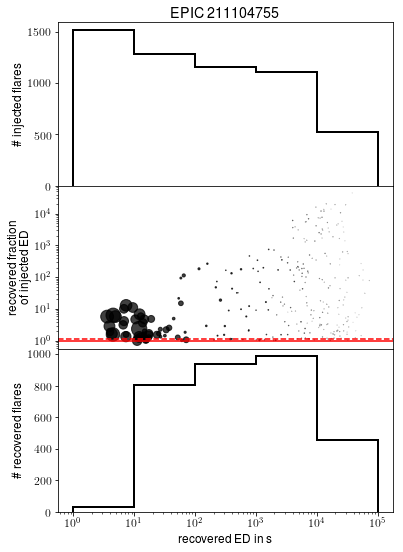

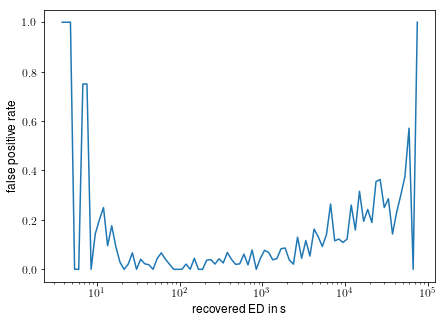

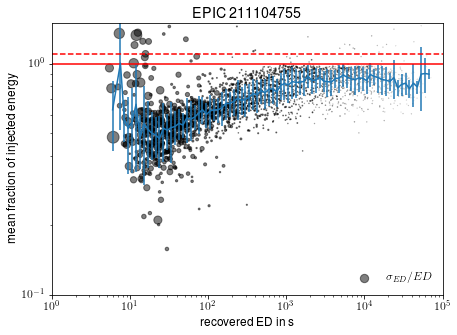

In [86]:
LCtype = 'everest'
test = 'run_12'
fakes = pd.read_csv("/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/{}_{}_allfakes.csv".format(cluster,test,oid,LCtype))
falsepos(fakes)
fprate(fakes,LCtype)
ratio(fakes)
ratio_mean(fakes,LCtype)


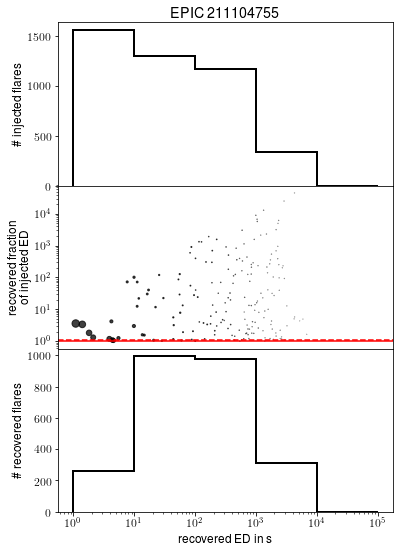

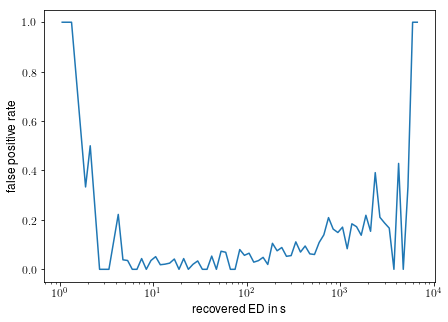

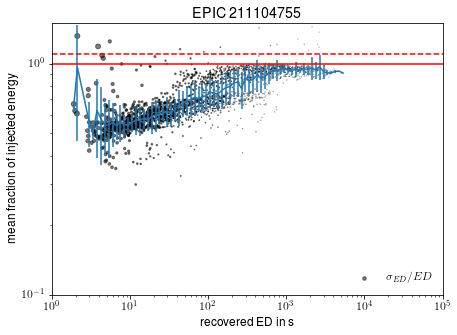

In [87]:
LCtype = 'k2sc'
test = 'run_11'
fakes = pd.read_csv("/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/{}_{}_allfakes.csv".format(cluster,test,oid,LCtype))

falsepos(fakes)
fprate(fakes,LCtype)
ratio(fakes)
ratio_mean(fakes,LCtype)
